In [1]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
# Load pickle file with balanced dataframe
with open(r'pickles\balanced_retokenized_pt.pickle', 'rb') as f:
    data = pickle.load(f)

### Representação vetorial (Tf-Idf)

In [16]:
# Split data into features (X) and label (y)
X_data = np.array(data['title'])
y_data = np.array(data['label'])

# Apply Tf-Idf representation
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X_data)
X_data = vectorizer.transform(X_data)

### Redução de Dimensionalidade

#### Extração de Features (LSA - TruncatedSVD)

In [17]:
LSA = TruncatedSVD(n_components=100, n_iter=150, random_state=0)
LSA = LSA.fit(X_data)
X_data = LSA.transform(X_data)

## Modelagem de algoritmos

#### Naive Bayes

In [18]:
NB_classifier = GaussianNB()

#### Logistic Regression

In [19]:
LR_classifier = LogisticRegression(solver='saga', C=1000, penalty='l2', max_iter=1000)

#### K-Nearest-Neighboors

In [20]:
KNN_classifier = KNeighborsClassifier(n_neighbors=3)

#### Support Vector Machine

In [21]:
SVM_classifier = SVC(kernel='rbf', probability=True, gamma='scale', C=100)

#### Multilayer Perceptron

In [23]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,50,50,25), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=1000)

In [24]:
def metrics(classifier, cv):
    print(f'======= MODEL {classifier.__class__.__name__} =======')
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12,7))
    for i, (train, test) in enumerate(cv.split(X_data, y_data)):
        start_time = time.time()
        classifier.fit(X_data[train], y_data[train])
        predicted = classifier.predict(X_data[test])
        print(f'Cross-validate k={i}: precision={precision_score(predicted, y_data[test])}, recall={recall_score(predicted, y_data[test])}, f1={f1_score(predicted, y_data[test])}, time={time.time() - start_time}s')
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_data[test],
            y_data[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"ROC médio (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 desv. pad.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"ROC para o modelo {classifier.__class__.__name__} com validação cruzada 10-fold",
    )
    ax.legend(loc="lower right")
    ax.set_xlabel('Taxa de Falso Positivo (FP) (classe positiva: 1)', fontsize=12)
    ax.set_ylabel('Taxa de Verdadeiro Positivo (VP) (classe positiva: 1)', fontsize=12)
    plt.show()

======= MODEL GaussianNB =======
Cross-validate k=0: precision=0.8714421252371917, recall=0.8411172161172161, f1=0.8560111835973905, time=0.056359291076660156s
Cross-validate k=1: precision=0.9032258064516129, recall=0.8611488014473089, f1=0.8816855753646677, time=0.05292630195617676s
Cross-validate k=2: precision=0.9117647058823529, recall=0.8576528335564481, f1=0.8838813520349507, time=0.05198192596435547s
Cross-validate k=3: precision=0.885673624288425, recall=0.8406123367852318, f1=0.8625548625548625, time=0.055845022201538086s
Cross-validate k=4: precision=0.8885199240986718, recall=0.8399103139013453, f1=0.8635315813739051, time=0.052959442138671875s
Cross-validate k=5: precision=0.8738140417457305, recall=0.9326582278481013, f1=0.902277736958119, time=0.051667213439941406s
Cross-validate k=6: precision=0.8833017077798861, recall=0.8866666666666667, f1=0.8849809885931559, time=0.05203986167907715s
Cross-validate k=7: precision=0.8875711574952562, recall=0.8747078073866292, f1=0.8

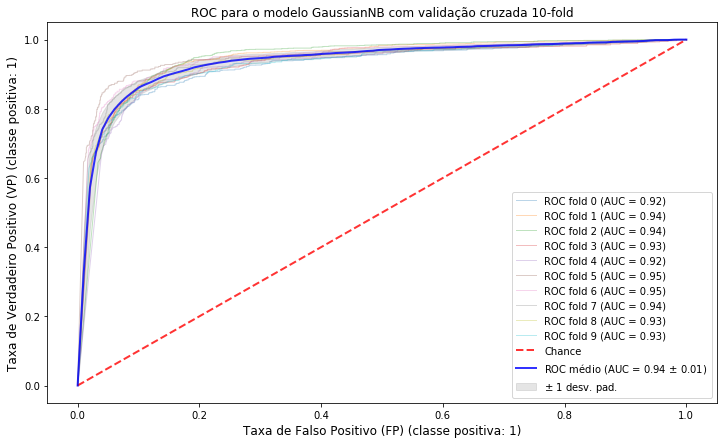

======= MODEL LogisticRegression =======
Cross-validate k=0: precision=0.797438330170778, recall=0.910124526258798, f1=0.8500632111251581, time=0.8622169494628906s
Cross-validate k=1: precision=0.888045540796964, recall=0.841726618705036, f1=0.8642659279778394, time=0.7831113338470459s
Cross-validate k=2: precision=0.9122390891840607, recall=0.8203924914675768, f1=0.8638814016172506, time=0.6219115257263184s
Cross-validate k=3: precision=0.8202087286527514, recall=0.8688442211055276, f1=0.8438262567105905, time=0.6935443878173828s
Cross-validate k=4: precision=0.8277988614800759, recall=0.7779759251003121, f1=0.8021144564467938, time=0.7011957168579102s
Cross-validate k=5: precision=0.8206831119544592, recall=0.7508680555555556, f1=0.7842248413417952, time=0.6940183639526367s
Cross-validate k=6: precision=0.8240037950664136, recall=0.9046875, f1=0.862462760675273, time=0.7353923320770264s
Cross-validate k=7: precision=0.8078747628083491, recall=0.9200432198811453, f1=0.8603182621874211

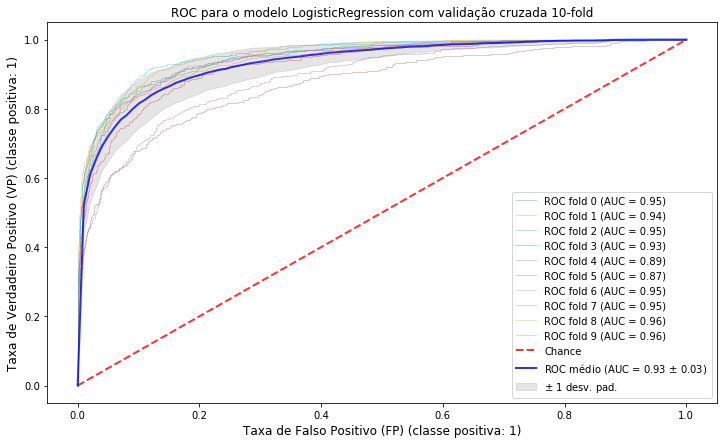

======= MODEL KNeighborsClassifier =======
Cross-validate k=0: precision=1.0, recall=0.9957487009919698, f1=0.9978698224852072, time=5.0485999584198s
Cross-validate k=1: precision=0.9810246679316889, recall=0.9937530033637674, f1=0.9873478157078062, time=4.614782810211182s
Cross-validate k=2: precision=0.976280834914611, recall=0.9966101694915255, f1=0.9863407620416966, time=4.747903823852539s
Cross-validate k=3: precision=1.0, recall=0.9957487009919698, f1=0.9978698224852072, time=4.781890153884888s
Cross-validate k=4: precision=1.0, recall=0.9915333960489181, f1=0.9957487009919698, time=4.712301254272461s
Cross-validate k=5: precision=1.0, recall=0.9915333960489181, f1=0.9957487009919698, time=4.709744215011597s
Cross-validate k=6: precision=1.0, recall=0.996219281663516, f1=0.9981060606060606, time=4.5089194774627686s
Cross-validate k=7: precision=1.0, recall=0.9952785646836638, f1=0.9976336961665878, time=3.226365089416504s
Cross-validate k=8: precision=1.0, recall=0.99763369616658

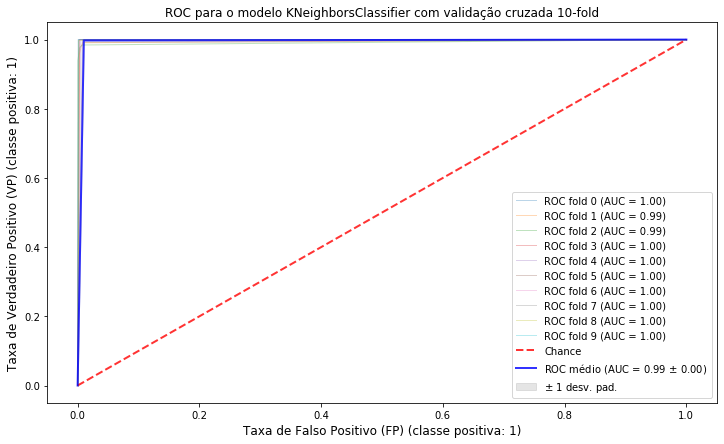

======= MODEL SVC =======
Cross-validate k=0: precision=1.0, recall=0.9952785646836638, f1=0.9976336961665878, time=155.95384979248047s
Cross-validate k=1: precision=0.9715370018975332, recall=0.9927290353853612, f1=0.9820187005514266, time=112.24421811103821s
Cross-validate k=2: precision=0.9601518026565465, recall=0.989247311827957, f1=0.9744824265767934, time=93.13529706001282s
Cross-validate k=3: precision=1.0, recall=0.9929345266132831, f1=0.9964547388324273, time=162.2804732322693s
Cross-validate k=4: precision=1.0, recall=0.9841269841269841, f1=0.9919999999999999, time=150.5708589553833s
Cross-validate k=5: precision=1.0, recall=0.9896713615023475, f1=0.9948088721094855, time=158.88754892349243s
Cross-validate k=6: precision=1.0, recall=0.9929345266132831, f1=0.9964547388324273, time=156.45924973487854s
Cross-validate k=7: precision=1.0, recall=0.9915333960489181, f1=0.9957487009919698, time=161.96189761161804s
Cross-validate k=8: precision=1.0, recall=0.9966903073286052, f1=0.9

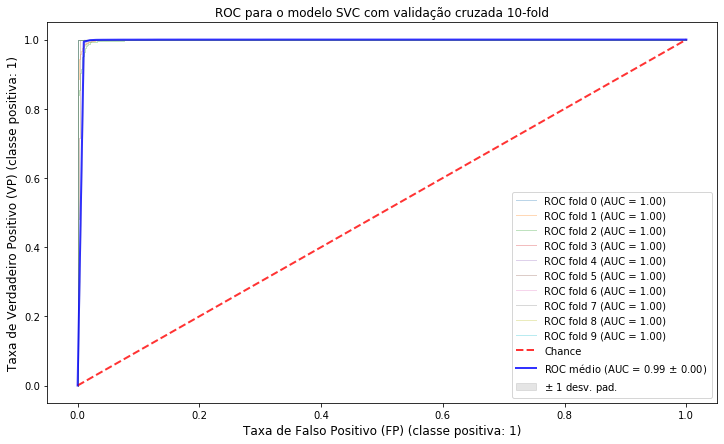

======= MODEL MLPClassifier =======
Cross-validate k=0: precision=1.0, recall=0.9915333960489181, f1=0.9957487009919698, time=18.394419193267822s
Cross-validate k=1: precision=0.9644212523719166, recall=0.9888132295719845, f1=0.9764649375600386, time=28.765837907791138s
Cross-validate k=2: precision=0.9340607210626186, recall=0.988950276243094, f1=0.9607221273481337, time=28.187278032302856s
Cross-validate k=3: precision=1.0, recall=0.9868913857677902, f1=0.9934024505183789, time=26.68355369567871s
Cross-validate k=4: precision=0.99573055028463, recall=0.9900943396226415, f1=0.9929044465468306, time=27.18999433517456s
Cross-validate k=5: precision=1.0, recall=0.989206945096199, f1=0.9945741920264214, time=32.486597299575806s
Cross-validate k=6: precision=1.0, recall=0.9887429643527205, f1=0.9943396226415094, time=35.52570152282715s
Cross-validate k=7: precision=1.0, recall=0.9882794186591655, f1=0.9941051638764442, time=20.416313886642456s
Cross-validate k=8: precision=1.0, recall=0.99

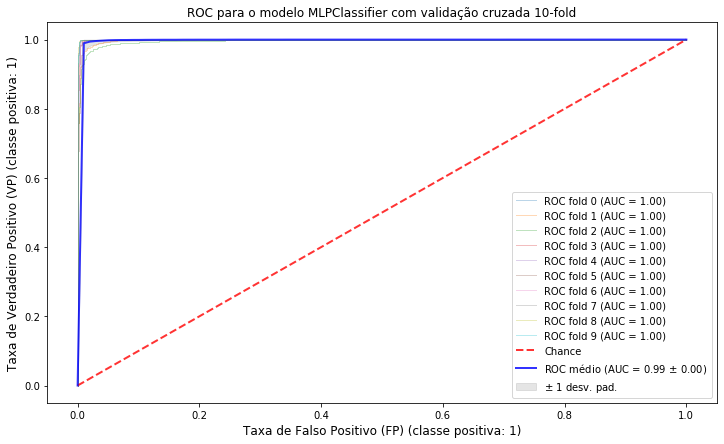

In [25]:
cv = StratifiedKFold(n_splits=10)
metrics(NB_classifier, cv)
metrics(LR_classifier, cv)
metrics(KNN_classifier, cv)
metrics(SVM_classifier, cv)
metrics(MLP_classifier, cv)